## Data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import os

# Ścieżka do pliku CSV i folderu z obrazami
csv_file_path = 'labels.csv'
images_folder_path = 'images/'

# Wczytanie danych z pliku CSV
data = pd.read_csv(csv_file_path)

# Dodanie pełnej ścieżki do każdego obrazu
data['image_path'] = data['Filename'].apply(lambda x: os.path.join(images_folder_path, x))

In [4]:
data

,Filename,Label,Species,image_path
0,20160928-140314-0.jpg,0,Chinee apple,images/20160928-140314-0.jpg
1,20160928-140337-0.jpg,0,Chinee apple,images/20160928-140337-0.jpg
2,20160928-140731-0.jpg,0,Chinee apple,images/20160928-140731-0.jpg
3,20160928-140747-0.jpg,0,Chinee apple,images/20160928-140747-0.jpg
4,20160928-141107-0.jpg,0,Chinee apple,images/20160928-141107-0.jpg
...,...,...,...,...
17504,20180322-133822-1.jpg,8,Negative,images/20180322-133822-1.jpg
17505,20180322-133832-1.jpg,8,Negative,images/20180322-133832-1.jpg
17506,20180322-133840-1.jpg,8,Negative,images/20180322-133840-1.jpg
17507,20180322-133850-1.jpg,8,Negative,images/20180322-133850-1.jpg


In [5]:
data.drop("Filename", axis=1, inplace=True)

In [6]:
counts = data.value_counts("Label").sort_index()
counts

Label
0    1125
1    1064
2    1031
3    1022
4    1062
5    1009
6    1074
7    1016
8    9106
Name: count, dtype: int64

### Oversampling

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

# Podział danych na treningowe i testowe
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42)

# Oversampling tylko danych treningowych
ros = RandomOverSampler(random_state=42)
train_data_oversampled, _ = ros.fit_resample(train_data, train_data['Label'])

# Konwersja wyników oversamplingu z powrotem na DataFrame
train_data_oversampled = pd.DataFrame(train_data_oversampled, columns=train_data.columns)
train_data_oversampled = shuffle(train_data_oversampled, random_state=42)

In [8]:
print(train_data_oversampled['Label'].value_counts())

Label
1    7285
7    7285
0    7285
8    7285
2    7285
6    7285
4    7285
3    7285
5    7285
Name: count, dtype: int64


In [9]:
train_data_oversampled

,Label,Species,image_path
25219,1,Lantana,images/20170714-142520-2.jpg
63528,7,Snake weed,images/20180109-092016-2.jpg
20485,1,Lantana,images/20170714-115830-2.jpg
15306,0,Chinee apple,images/20170210-133358-0.jpg
144,8,Negative,images/20170728-150742-3.jpg
...,...,...,...
37194,3,Parthenium,images/20170906-095922-1.jpg
6265,8,Negative,images/20171219-100626-3.jpg
54886,6,Siam weed,images/20171113-143650-0.jpg
860,5,Rubber vine,images/20171113-094525-3.jpg


### Image processing

In [10]:
# Ustawienie rozmiaru docelowego obrazu
IMG_SIZE = 224

def process_image_and_label(image_path, label, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalizacja wartości pikseli

    if augment:
        image, label = apply_augmentation(image, label)

    return image, label

### Augmentation

In [11]:
def apply_augmentation(image, label):
    # Losowe odbicie lustrzane w poziomie
    image = tf.image.random_flip_left_right(image)
    # Losowe odbicie lustrzane w pionie
    image = tf.image.random_flip_up_down(image)
    # Losowa zmiana jasności
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Losowa zmiana kontrastu
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Losowe obracanie obrazu
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Dodanie szumu Gaussowskiego
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image = tf.add(image, noise)
    # Ucinanie wartości pikseli do zakresu [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

### Preparing datasets

In [12]:
def prepare_dataset(dataframe, batch_size, augment=False):
    image_paths = dataframe['image_path'].values
    labels = dataframe['Label'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: process_image_and_label(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Przykładowe użycie
BATCH_SIZE = 32

# Przygotowanie danych treningowych z augmentacją
train_dataset = prepare_dataset(train_data_oversampled, BATCH_SIZE, augment=True)

# Przygotowanie danych testowych bez augmentacji
test_dataset = prepare_dataset(test_data, BATCH_SIZE, augment=False)

### Showing random augmented picture|

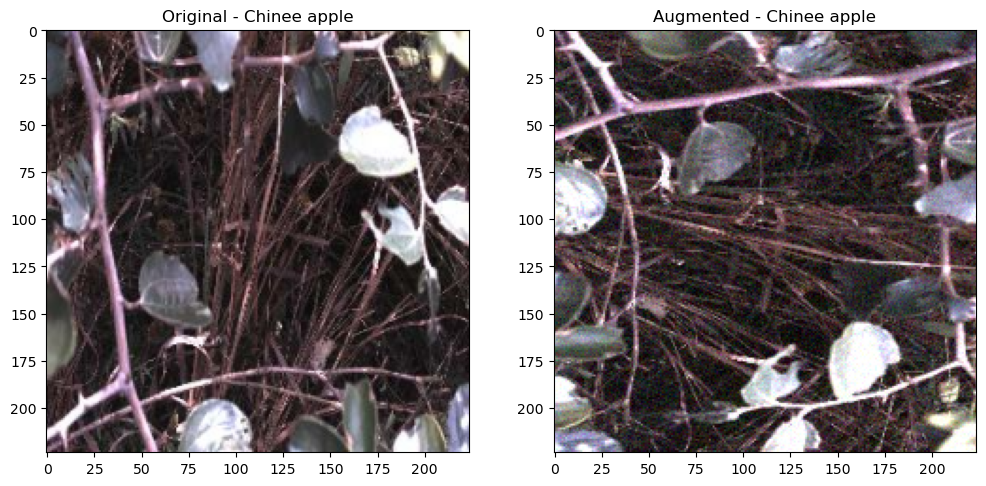

In [13]:
import random

def show_random_image_with_and_without_augmentation(dataframe, augment=True):
    # Losowe wybranie obrazu
    random_idx = random.randint(0, len(dataframe) - 1)
    image_path = dataframe.iloc[random_idx]['image_path']
    species = dataframe.iloc[random_idx]['Species']
    label = dataframe.iloc[random_idx]['Label']

    # Wczytanie i przetworzenie obrazu bez augmentacji
    image, _ = process_image_and_label(image_path, label, augment=False)

    # Wczytanie i przetworzenie obrazu z augmentacją (jeśli augment=True)
    augmented_image, _ = process_image_and_label(image_path, label, augment=augment)

    # Konwersja obrazów z tensorów na numpy arrays
    image = image.numpy()
    augmented_image = augmented_image.numpy()

    # Wyświetlenie obrazów
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Original - {species}')

    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title(f'Augmented - {species}')

    plt.show()

# Wywołanie funkcji dla przykładowego DataFrame
show_random_image_with_and_without_augmentation(train_data_oversampled, augment=True)

### Training history

In [14]:
def plot_training_history(history):
    
    # Wykres dokładności
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Wykres straty
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

## Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model_v2 = Sequential([
    # Pierwsza warstwa konwolucyjna z Batch Normalization
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Druga warstwa konwolucyjna
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Trzecia warstwa konwolucyjna
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Czwarta warstwa konwolucyjna
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Czwarta warstwa konwolucyjna
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Global Average Pooling
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(9, activation='softmax')  # Zakładam, że mamy 9 klas
])

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps=10000,
#     decay_rate=0.9)

model_v2.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [16]:
model_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, restore_best_weights=True)

checkpoint_cb = ModelCheckpoint(
    'model_v2_best',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

history = model_v2.fit(
    train_dataset,
    epochs=35,
    validation_data=test_dataset,
    callbacks=[early_stopping_callback, checkpoint_cb],
    # class_weight=class_weights_dict 
)

Epoch 1/35
2049/2049 [==============================] - ETA: 0s - loss: 1.7881 - accuracy: 0.5305

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 343s 163ms/step - loss: 1.7881 - accuracy: 0.5305 - val_loss: 2.5837 - val_accuracy: 0.3698
Epoch 2/35
2049/2049 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.7394

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 287s 140ms/step - loss: 0.9543 - accuracy: 0.7394 - val_loss: 1.9403 - val_accuracy: 0.4300
Epoch 3/35
2049/2049 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.8237

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 289s 141ms/step - loss: 0.6933 - accuracy: 0.8237 - val_loss: 1.1599 - val_accuracy: 0.6670
Epoch 4/35
2049/2049 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.8695

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 285s 139ms/step - loss: 0.5535 - accuracy: 0.8695 - val_loss: 1.0607 - val_accuracy: 0.7190
Epoch 5/35
2049/2049 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.8939

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 292s 143ms/step - loss: 0.4764 - accuracy: 0.8939 - val_loss: 0.9251 - val_accuracy: 0.7610
Epoch 6/35
2049/2049 [==============================] - 292s 142ms/step - loss: 0.4247 - accuracy: 0.9103 - val_loss: 1.3399 - val_accuracy: 0.6705
Epoch 7/35
2049/2049 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.9245

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 293s 143ms/step - loss: 0.3820 - accuracy: 0.9245 - val_loss: 0.7494 - val_accuracy: 0.8395
Epoch 8/35
2049/2049 [==============================] - 294s 144ms/step - loss: 0.3517 - accuracy: 0.9317 - val_loss: 1.0885 - val_accuracy: 0.7601
Epoch 9/35
2049/2049 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.9377

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 298s 145ms/step - loss: 0.3335 - accuracy: 0.9377 - val_loss: 0.6879 - val_accuracy: 0.8407
Epoch 10/35
2049/2049 [==============================] - 302s 147ms/step - loss: 0.3113 - accuracy: 0.9435 - val_loss: 0.8565 - val_accuracy: 0.7913
Epoch 11/35
2049/2049 [==============================] - 296s 145ms/step - loss: 0.3002 - accuracy: 0.9457 - val_loss: 0.7613 - val_accuracy: 0.8270
Epoch 12/35
2049/2049 [==============================] - 296s 145ms/step - loss: 0.2876 - accuracy: 0.9498 - val_loss: 0.9063 - val_accuracy: 0.8090
Epoch 13/35
2049/2049 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.9530

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 292s 143ms/step - loss: 0.2734 - accuracy: 0.9530 - val_loss: 0.6933 - val_accuracy: 0.8492
Epoch 14/35
2049/2049 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9548

INFO:tensorflow:Assets written to: model_v2_best\assets


INFO:tensorflow:Assets written to: model_v2_best\assets


2049/2049 [==============================] - 295s 144ms/step - loss: 0.2631 - accuracy: 0.9548 - val_loss: 0.6526 - val_accuracy: 0.8644
Epoch 15/35
2049/2049 [==============================] - 304s 148ms/step - loss: 0.2514 - accuracy: 0.9585 - val_loss: 0.6885 - val_accuracy: 0.8458
Epoch 16/35
2049/2049 [==============================] - 301s 147ms/step - loss: 0.2403 - accuracy: 0.9612 - val_loss: 1.4147 - val_accuracy: 0.6896
Epoch 17/35
2049/2049 [==============================] - 289s 141ms/step - loss: 0.2358 - accuracy: 0.9618 - val_loss: 0.8059 - val_accuracy: 0.8284
Epoch 18/35
2049/2049 [==============================] - 292s 142ms/step - loss: 0.2296 - accuracy: 0.9637 - val_loss: 0.7059 - val_accuracy: 0.8395
Epoch 18: early stopping


In [17]:
model_v2.evaluate(test_dataset)

110/110 [==============================] - 9s 44ms/step - loss: 3.0623 - accuracy: 0.0588


[3.0622682571411133, 0.05882352963089943]

In [16]:
from tensorflow.keras.models import load_model

best_model = load_model("model_v2_best")

In [17]:
best_model.evaluate(test_dataset)

110/110 [==============================] - 43s 330ms/step - loss: 0.6526 - accuracy: 0.8644


[0.6525734066963196, 0.8643631935119629]

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Przy założeniu, że test_dataset zawiera dane testowe bez etykiet
predictions = best_model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Etykiety rzeczywiste
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

110/110 [==============================] - 5s 43ms/step


In [19]:
print(classification_report(true_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       225
           1       0.75      0.94      0.84       213
           2       0.94      0.87      0.90       206
           3       0.94      0.85      0.89       204
           4       0.69      0.95      0.80       213
           5       0.66      0.96      0.78       202
           6       0.76      0.98      0.86       215
           7       0.85      0.74      0.79       203
           8       0.96      0.85      0.90      1821

    accuracy                           0.86      3502
   macro avg       0.82      0.88      0.84      3502
weighted avg       0.88      0.86      0.87      3502



Text(0.5, 1.0, 'Confusion Matrix Heatmap')

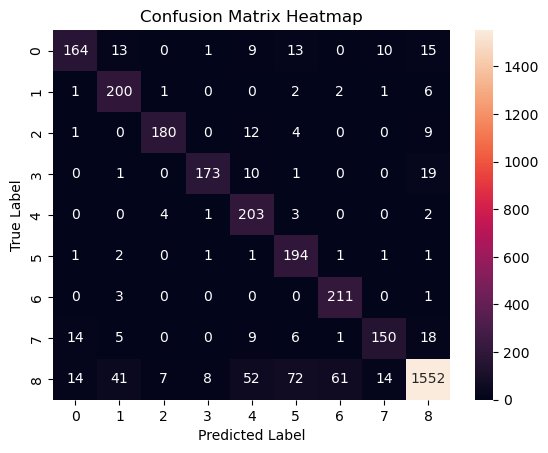

In [22]:
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_classes)

sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix Heatmap')

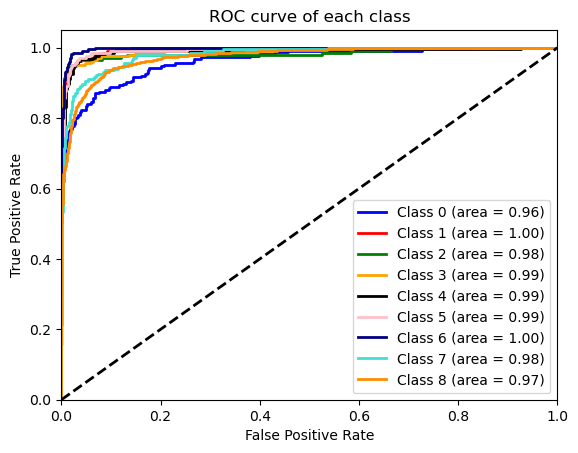

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizacja etykiet do oceny wieloklasowej
y_bin = label_binarize(true_labels, classes=np.arange(predictions.shape[1]))

# Obliczenie krzywej ROC i AUC dla każdej klasy
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(predictions.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Rysowanie krzywej ROC dla każdej klasy
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'pink', 'navy', 'turquoise', 'darkorange'])
for i, color in zip(range(predictions.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of each class')
plt.legend(loc="lower right")
plt.show()

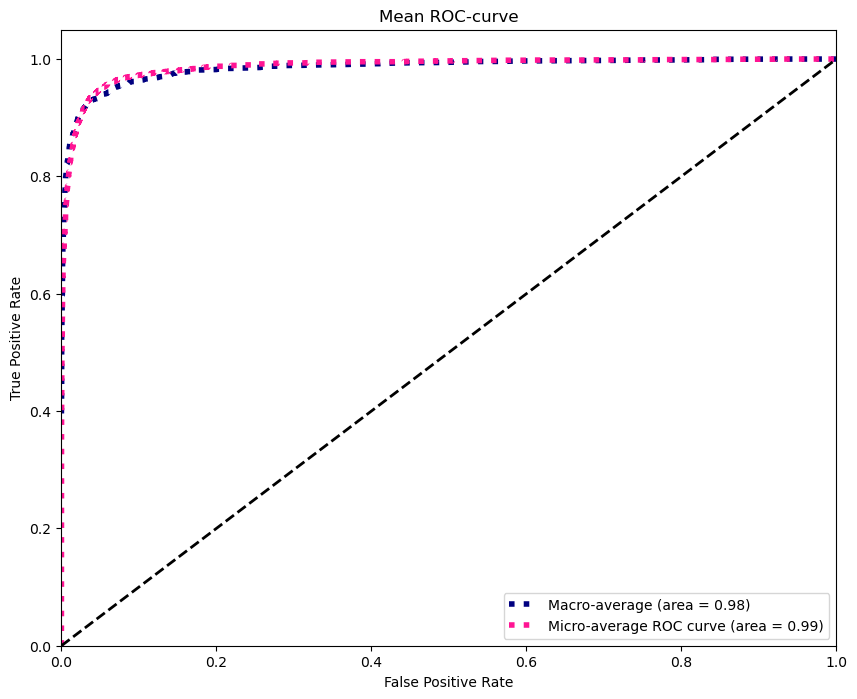

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Zbinaryzowanie etykiet
y_bin = label_binarize(true_labels, classes=np.arange(predictions.shape[1]))

# Obliczenie krzywej ROC i AUC dla każdej klasy
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(predictions.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Obliczenie makro-średniej ROC AUC
# Agregacja wszystkich fałszywie pozytywnych stawek
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(predictions.shape[1])]))

# Interpolacja wszystkich krzywych ROC w tym samym punkcie dla fałszywie pozytywnych stawek
mean_tpr = np.zeros_like(all_fpr)
for i in range(predictions.shape[1]):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Uśrednienie TPR i obliczenie AUC
mean_tpr /= predictions.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Obliczenie mikro-średniej ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Rysowanie makro-średniej ROC AUC
plt.figure(figsize=(10, 8))
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Rysowanie mikro-średniej ROC AUC
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# # Rysowanie ROC AUC dla każdej klasy
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(predictions.shape[1]), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC-curve')
plt.legend(loc="lower right")
plt.show()

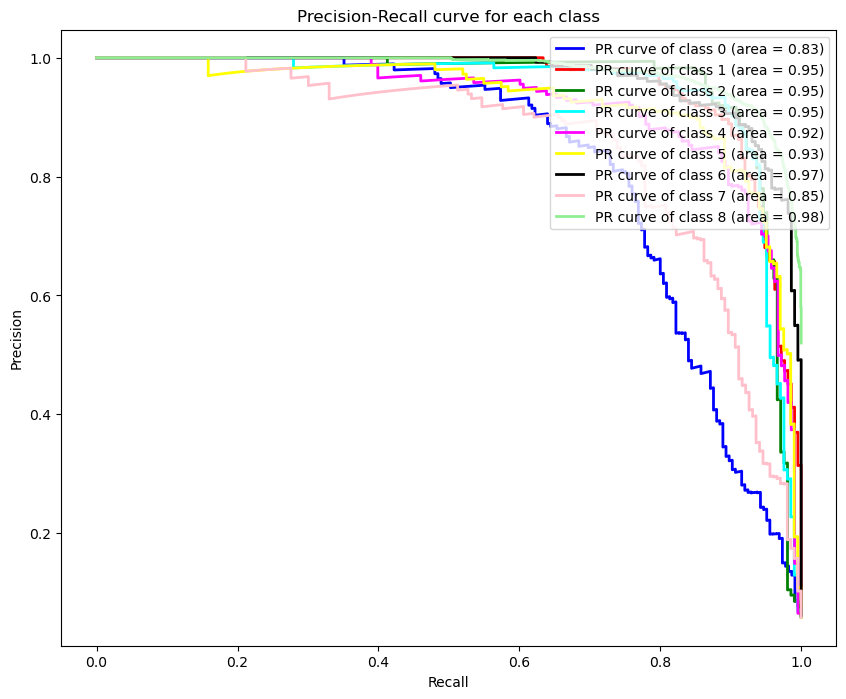

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Binarizowanie etykiet do postaci one-hot
y_bin = label_binarize(true_labels, classes=np.arange(predictions.shape[1]))

# Ustawienie cyklu kolorów dla wykresów różnych klas
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])

plt.figure(figsize=(10, 8))

# Rysowanie krzywej Precision-Recall dla każdej klasy
for i, color in zip(range(predictions.shape[1]), colors):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], predictions[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.2f})'.format(i, average_precision_score(y_bin[:, i], predictions[:, i])))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="upper right")
plt.show()

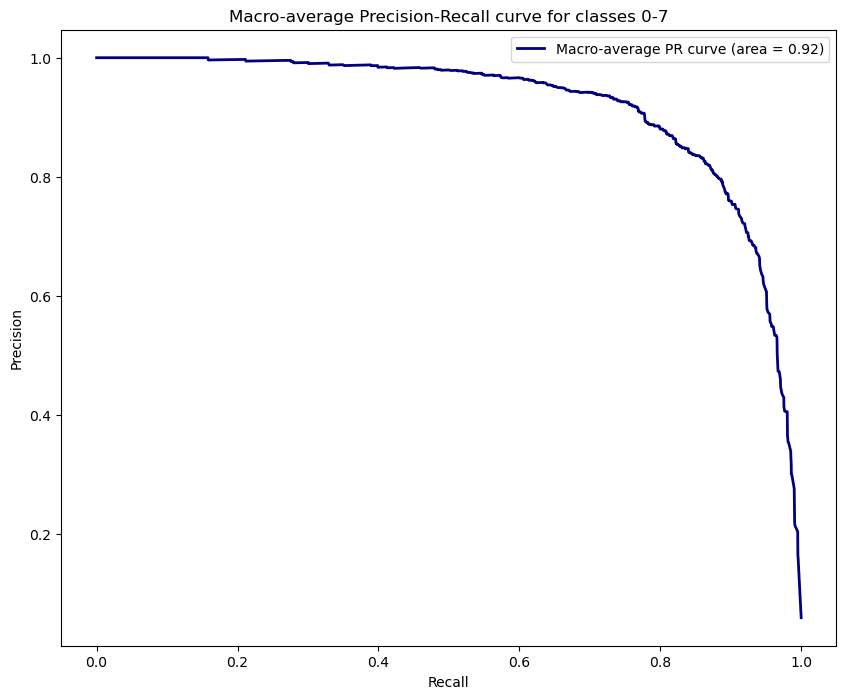

In [32]:
import numpy as np

# Binarizowanie etykiet do postaci one-hot
y_bin = label_binarize(true_labels, classes=np.arange(np.max(true_labels) + 1))

# Przygotowujemy listy do przechowania sum precision i recall
precision_list = []
recall_list = []
average_precision_list = []

# Liczymy precision i recall dla klas od 0 do 7
for i in range(8):  # Ograniczamy się do klas od 0 do 7
    precision, recall, _ = precision_recall_curve(y_bin[:, i], predictions[:, i])
    average_precision = average_precision_score(y_bin[:, i], predictions[:, i])
    precision_list.append(precision)
    recall_list.append(recall)
    average_precision_list.append(average_precision)

# Tworzymy jeden zestaw wartości recall poprzez połączenie wszystkich wartości recall i ich sortowanie
all_recall = np.unique(np.concatenate(recall_list))

# Interpolujemy wszystkie krzywe precision dla wspólnego zestawu wartości recall
mean_precision = np.zeros_like(all_recall)
for precision, recall in zip(precision_list, recall_list):
    mean_precision += np.interp(all_recall, recall[::-1], precision[::-1])

# Obliczamy średnią krzywą precision
mean_precision /= 8

# Obliczamy średnią wartość average precision
mean_average_precision = np.mean(average_precision_list)

# Rysujemy średnią krzywą Precision-Recall
plt.figure(figsize=(10, 8))
plt.plot(all_recall, mean_precision, label='Macro-average PR curve (area = {0:0.2f})'.format(mean_average_precision), color='navy', linestyle='-', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-average Precision-Recall curve for classes 0-7')
plt.legend(loc="best")
plt.show()